## Initial EDA

I queried the CDC WONDER database for the number of deaths due to myocardial infarction per month per state, for the years of 1999 to 2016. I then saved the results table as a text file, which is actually a comma-delimited file. The first step is to read this file in and turn it into a dataframe.

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pickle

%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = [8.0, 6.0]
plt.rcParams['figure.dpi'] = 250
plt.rcParams['savefig.dpi'] = 250
plt.rcParams['axes.titlesize'] = 20

In [4]:
with open("../data/myocardial_infarction.txt", "r") as f:
    lines = [line.rstrip('\n') for line in f]

lines = [line.replace('"', '') for line in lines]

split_lines = [line.split("\t") for line in lines]

In [5]:
df = pd.DataFrame(data=split_lines[1:], columns=split_lines[0])

In [6]:
df.head()

,Notes,State,State Code,Month,Month Code,Deaths,Population,Crude Rate
0,,Alabama,01,"Jan., 1999",1999/01,332,Not Applicable,Not Applicable
1,,Alabama,01,"Feb., 1999",1999/02,332,Not Applicable,Not Applicable
2,,Alabama,01,"Mar., 1999",1999/03,377,Not Applicable,Not Applicable
3,,Alabama,01,"Apr., 1999",1999/04,301,Not Applicable,Not Applicable
4,,Alabama,01,"May, 1999",1999/05,314,Not Applicable,Not Applicable


In [7]:
df['Month'] = pd.to_datetime(df['Month'])

df['Deaths'] = pd.to_numeric(df['Deaths'], errors='coerce')

deaths_grouped_state = df.groupby(['State'])[['Month', 'Deaths']]

In [8]:
state_mortality_dict = {}

for state in deaths_grouped_state.groups.keys():
    state_mortality_dict[state] = deaths_grouped_state.get_group(state).set_index('Month')

We can take a look at what the number of deaths per month due to MI is in California:

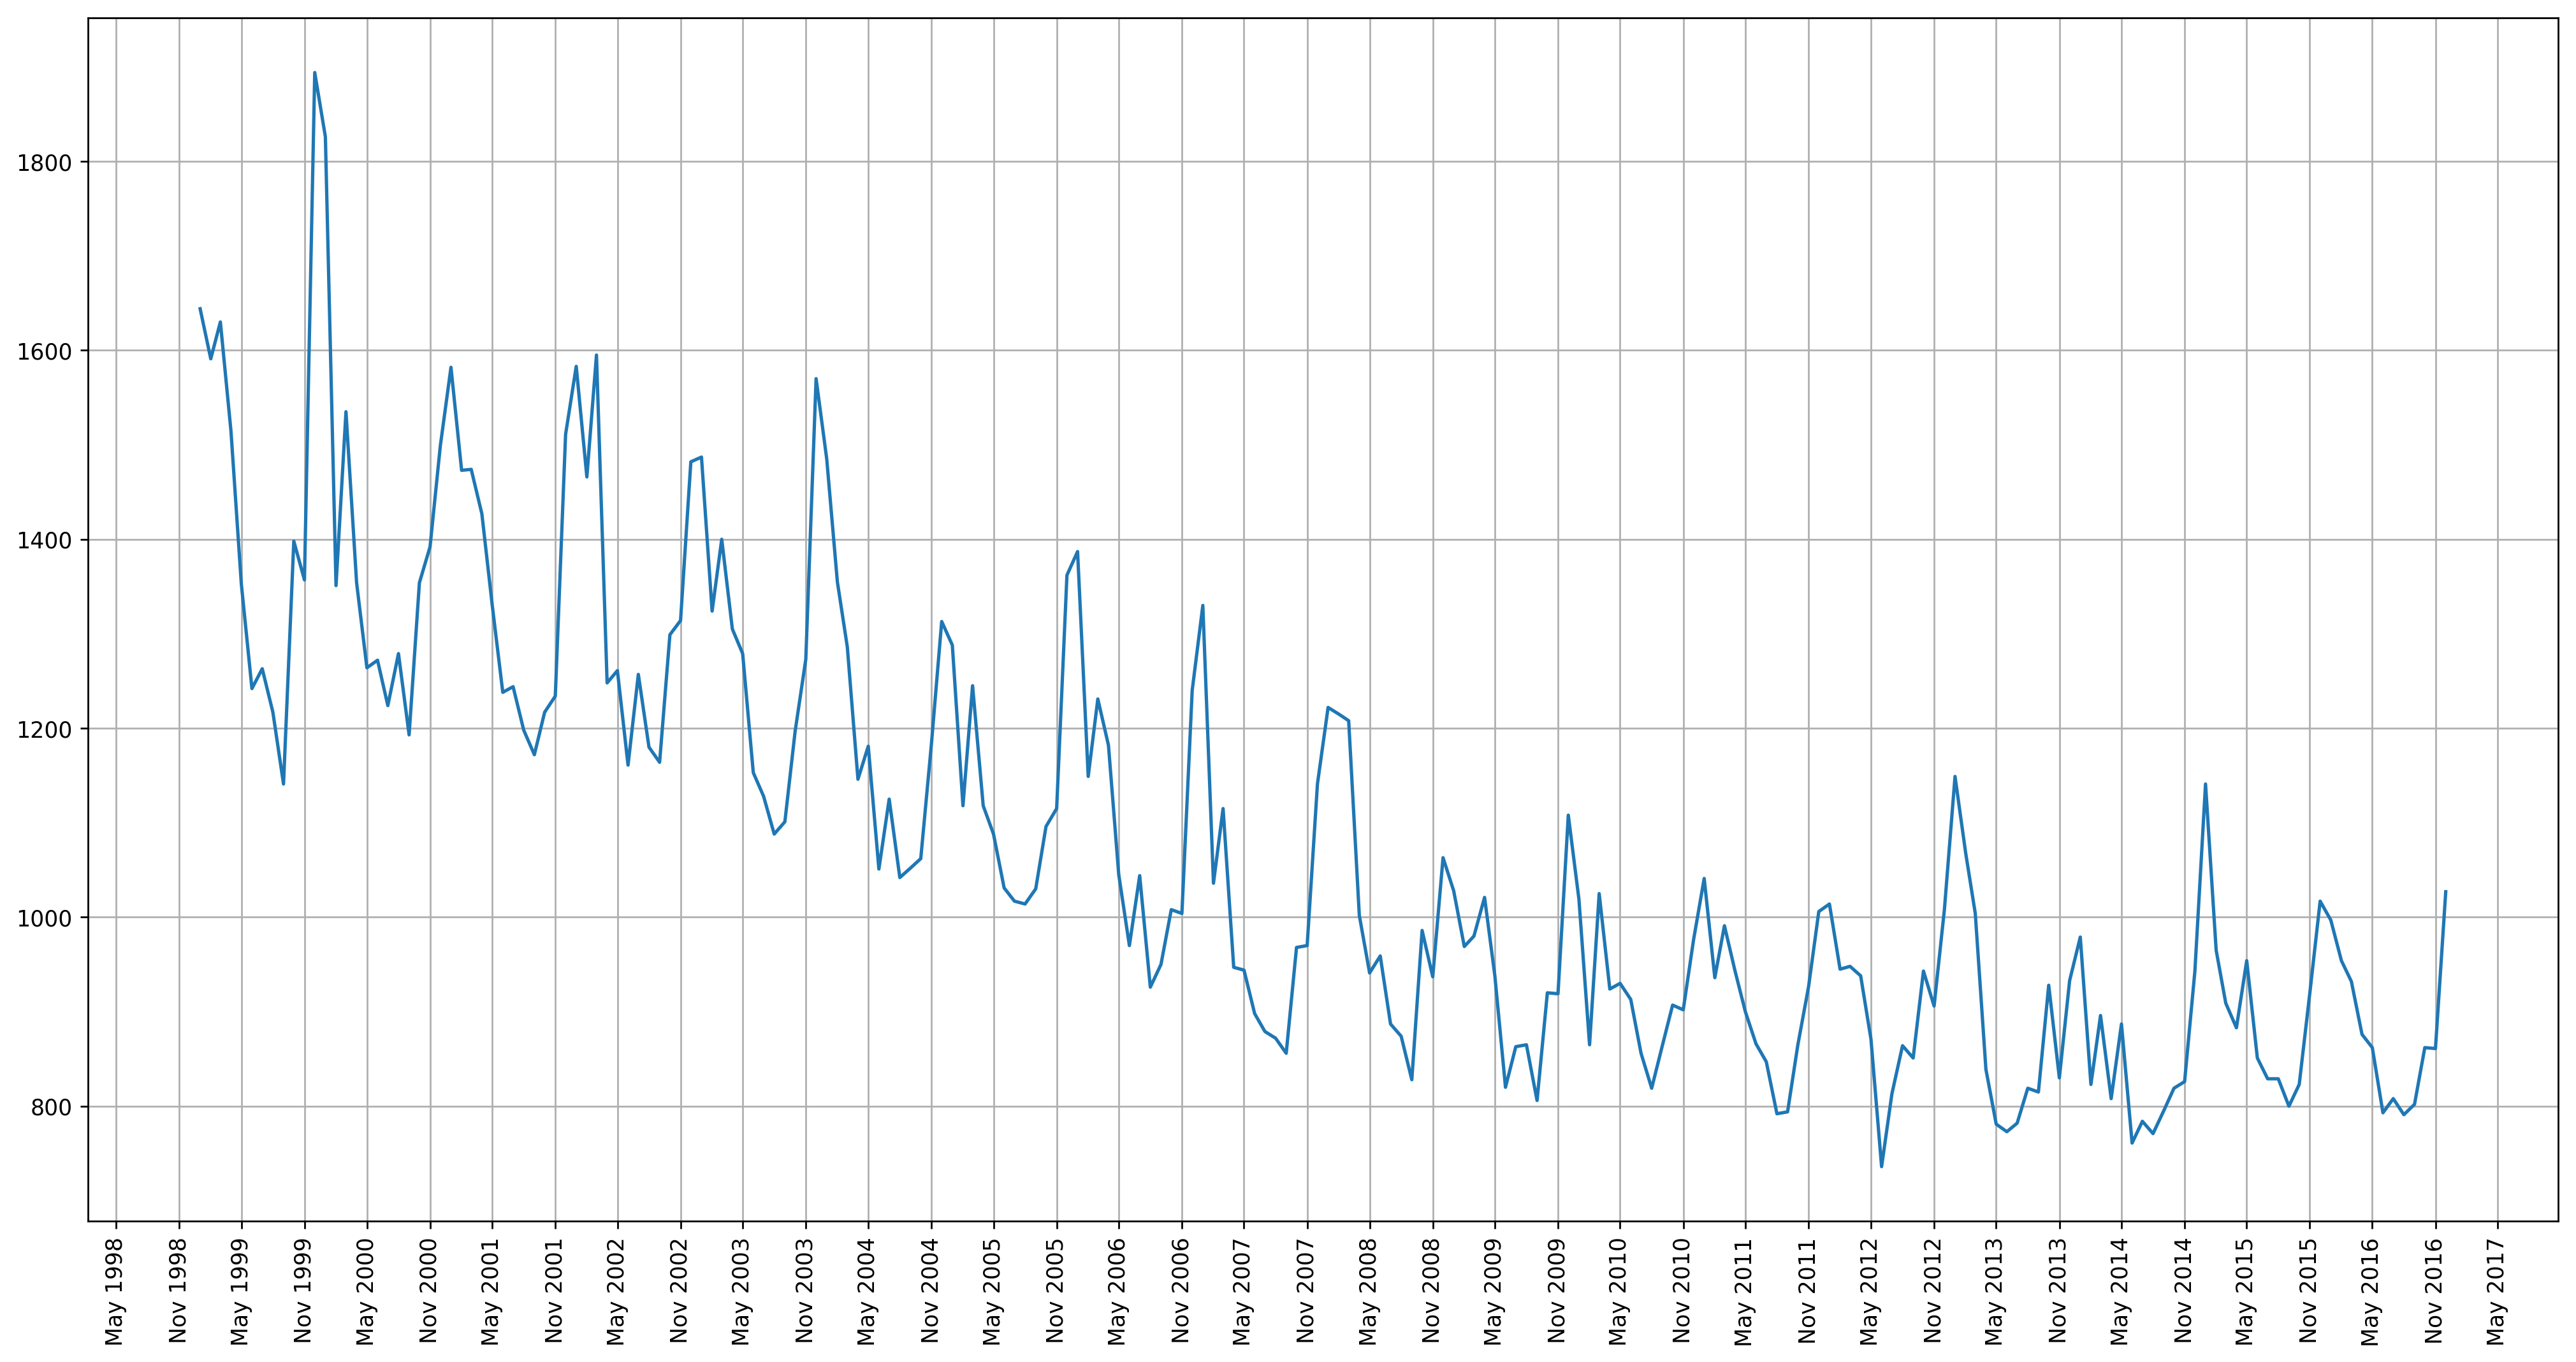

In [10]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1)  
plt.plot(state_mortality_dict['California'].index, state_mortality_dict['California'])
plt.xticks(rotation=90)
plt.grid()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

In [14]:
with open("../data/pickles/state_mortality_dict.pkl", "wb") as f:
    pickle.dump(state_mortality_dict, f)

## Trends and seasonality

We can take a look at what the overall trend is for California, and we can also decompose it into trend, seasonal, and residual series using statsmodels.

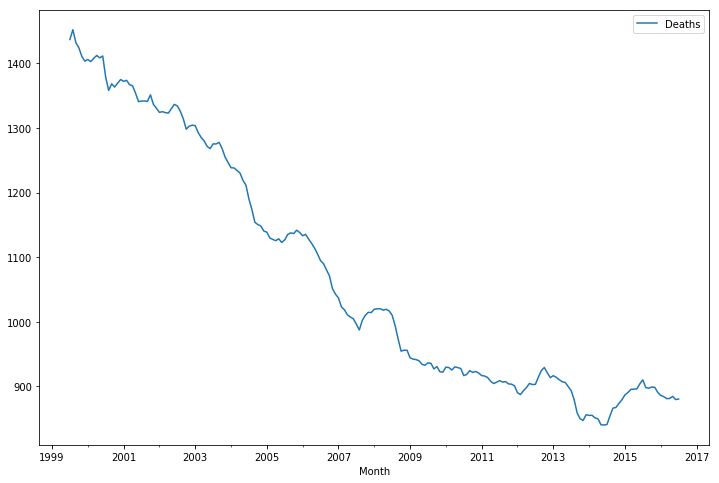

In [18]:
state_mortality_dict['California'].rolling(window=12, center=True).mean().plot()

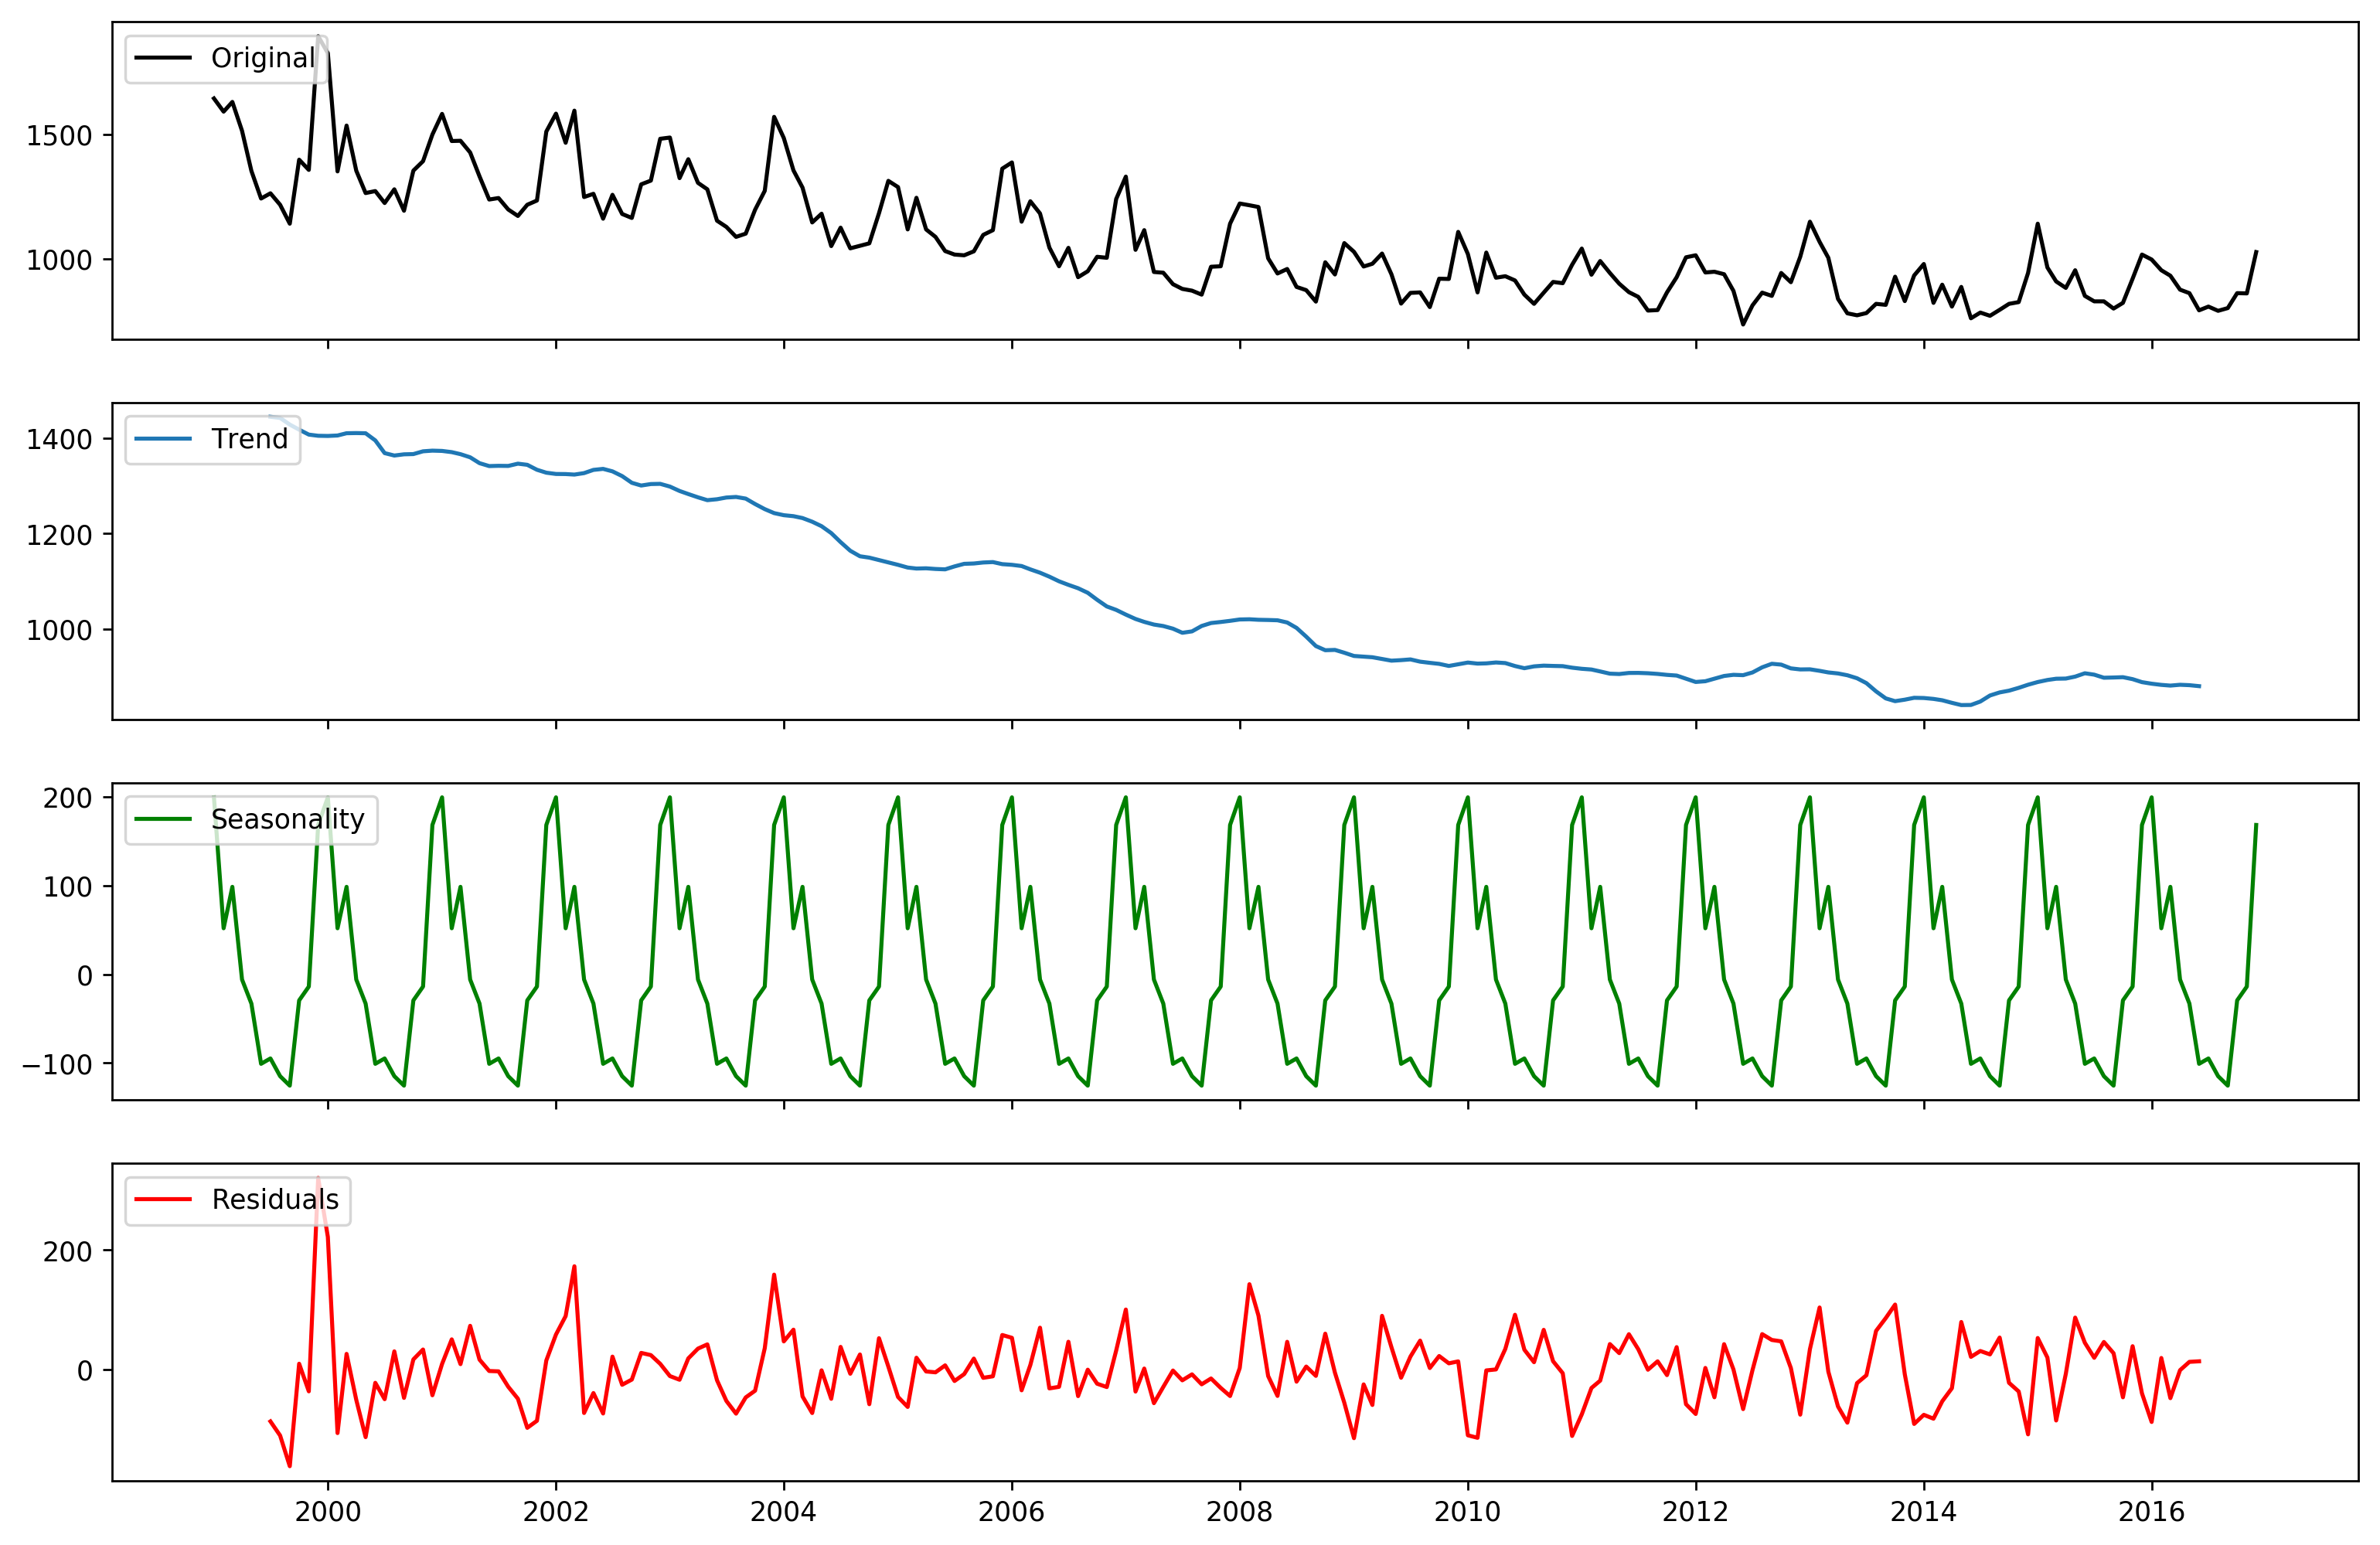

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
ss_decomposition = seasonal_decompose(x=state_mortality_dict['California'], 
                                      model='additive')
trend = ss_decomposition.trend
seasonal = ss_decomposition.seasonal
residual = ss_decomposition.resid

fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(state_mortality_dict['California'], 'k', label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(seasonal, 'g', label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(residual, 'r', label='Residuals')
axes[3].legend(loc='upper left')

Let's plot cardiac mortality per 100K (target) and also our two initial predictors (diabetes prevalence and obesity prevalence) and see what they look like.

In [4]:
with open("../data/pickles/cardiac_mortality_obesity_dm_df_by_state.pkl", "rb") as f:
    raw_MI_dm_df_by_state = pickle.load(f)

In [5]:
california_df = raw_MI_dm_df_by_state['California']

In [6]:
california_df.head()

,Deaths,obesity_prevalence,diabetes_prevalence,Population,mortality_per_100k
Month,,,,,
1999-01-01,1644.0,41.500000,6.50,33499204.0,4.907579
1999-02-01,1591.0,41.308333,6.55,33530241.0,4.744970
1999-03-01,1630.0,41.116667,6.60,33561278.0,4.856788
1999-04-01,1514.0,40.925000,6.65,33592315.0,4.506983
1999-05-01,1353.0,40.733333,6.70,33623352.0,4.023989


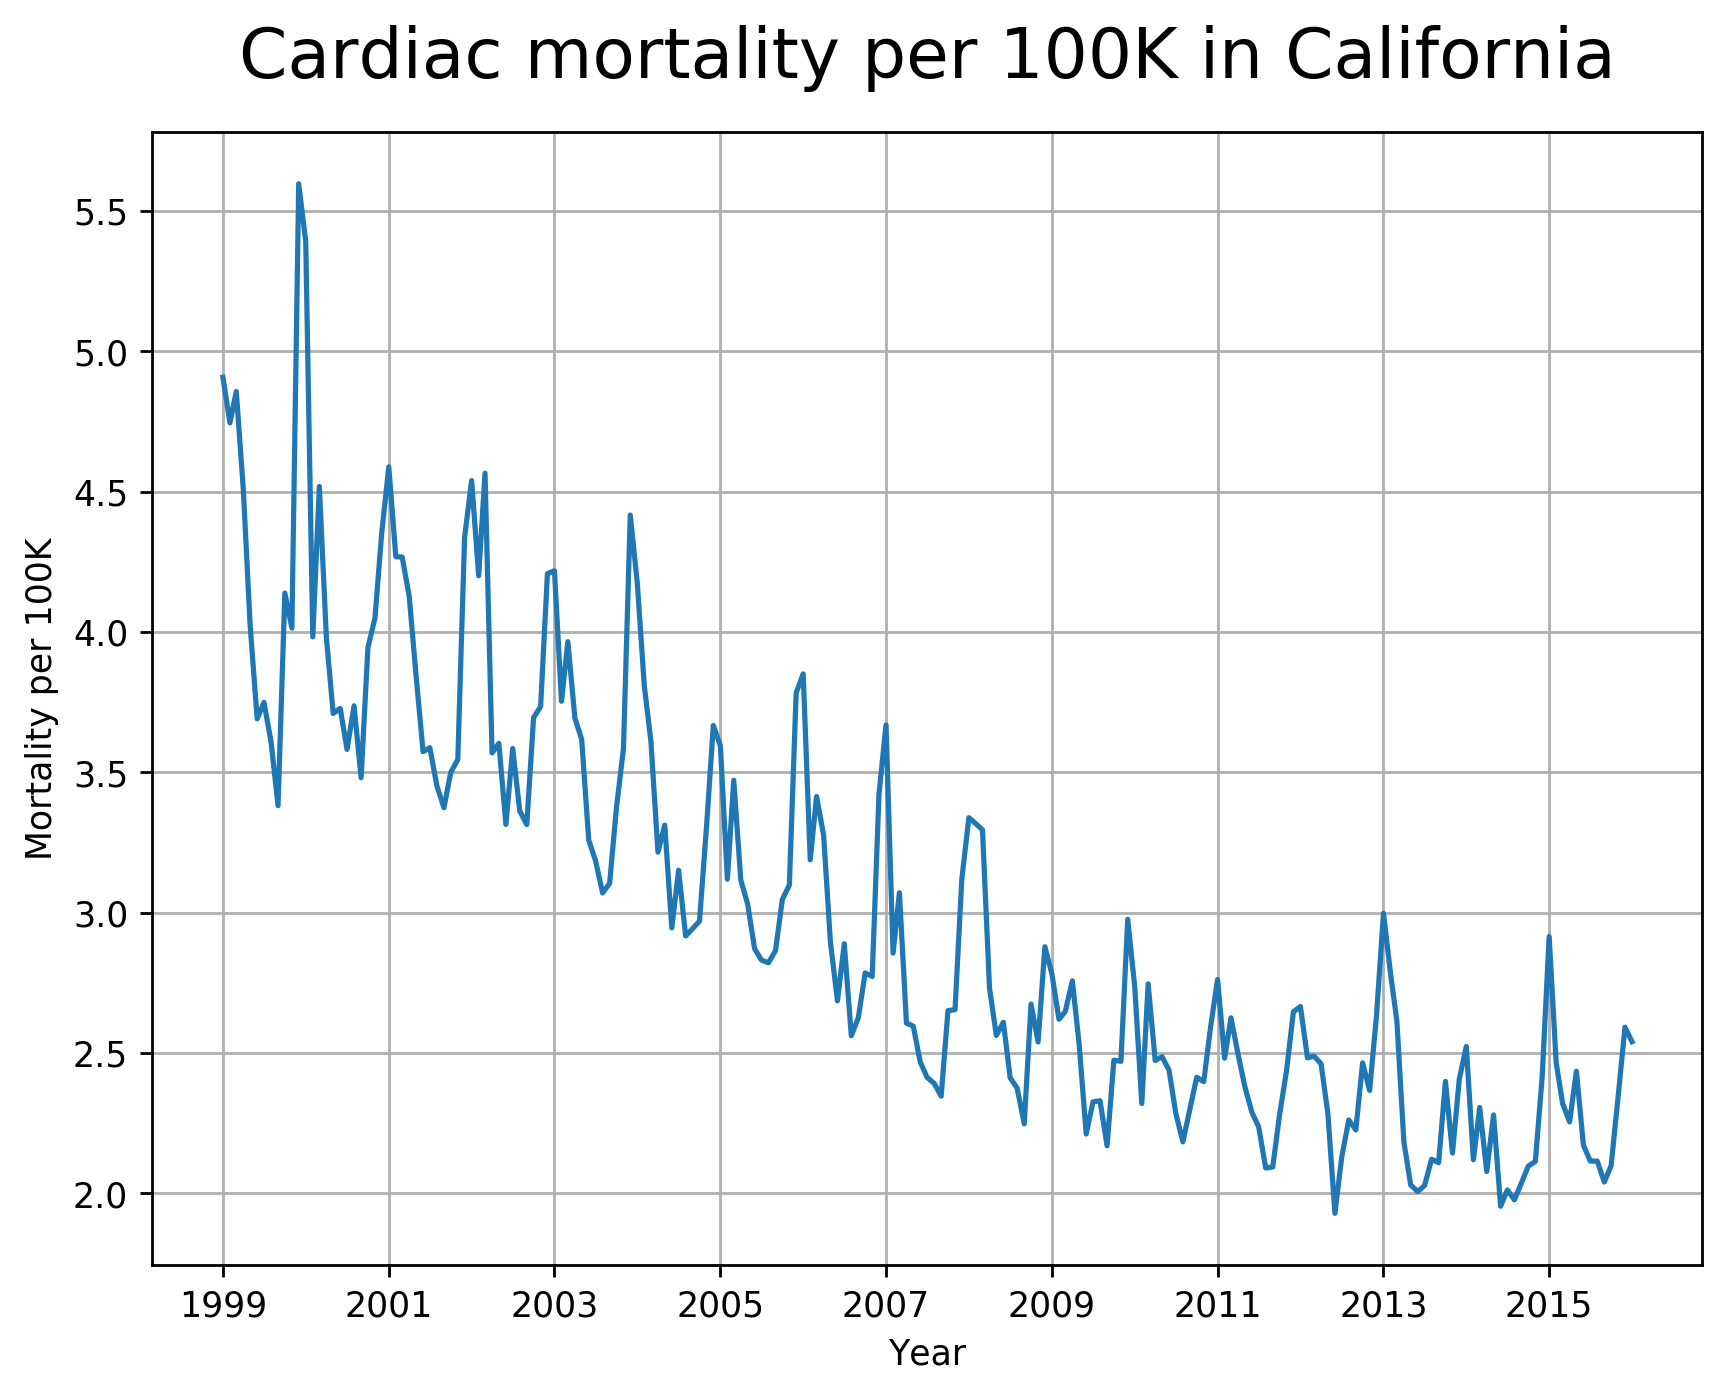

In [15]:
plt.plot(california_df.mortality_per_100k, label='California')

plt.xlabel("Year")
plt.ylabel("Mortality per 100K")

plt.title("Cardiac mortality per 100K in California", y=1.03)
plt.grid()
plt.savefig("../figures/california_cardiac_mortality.png")

plt.show()

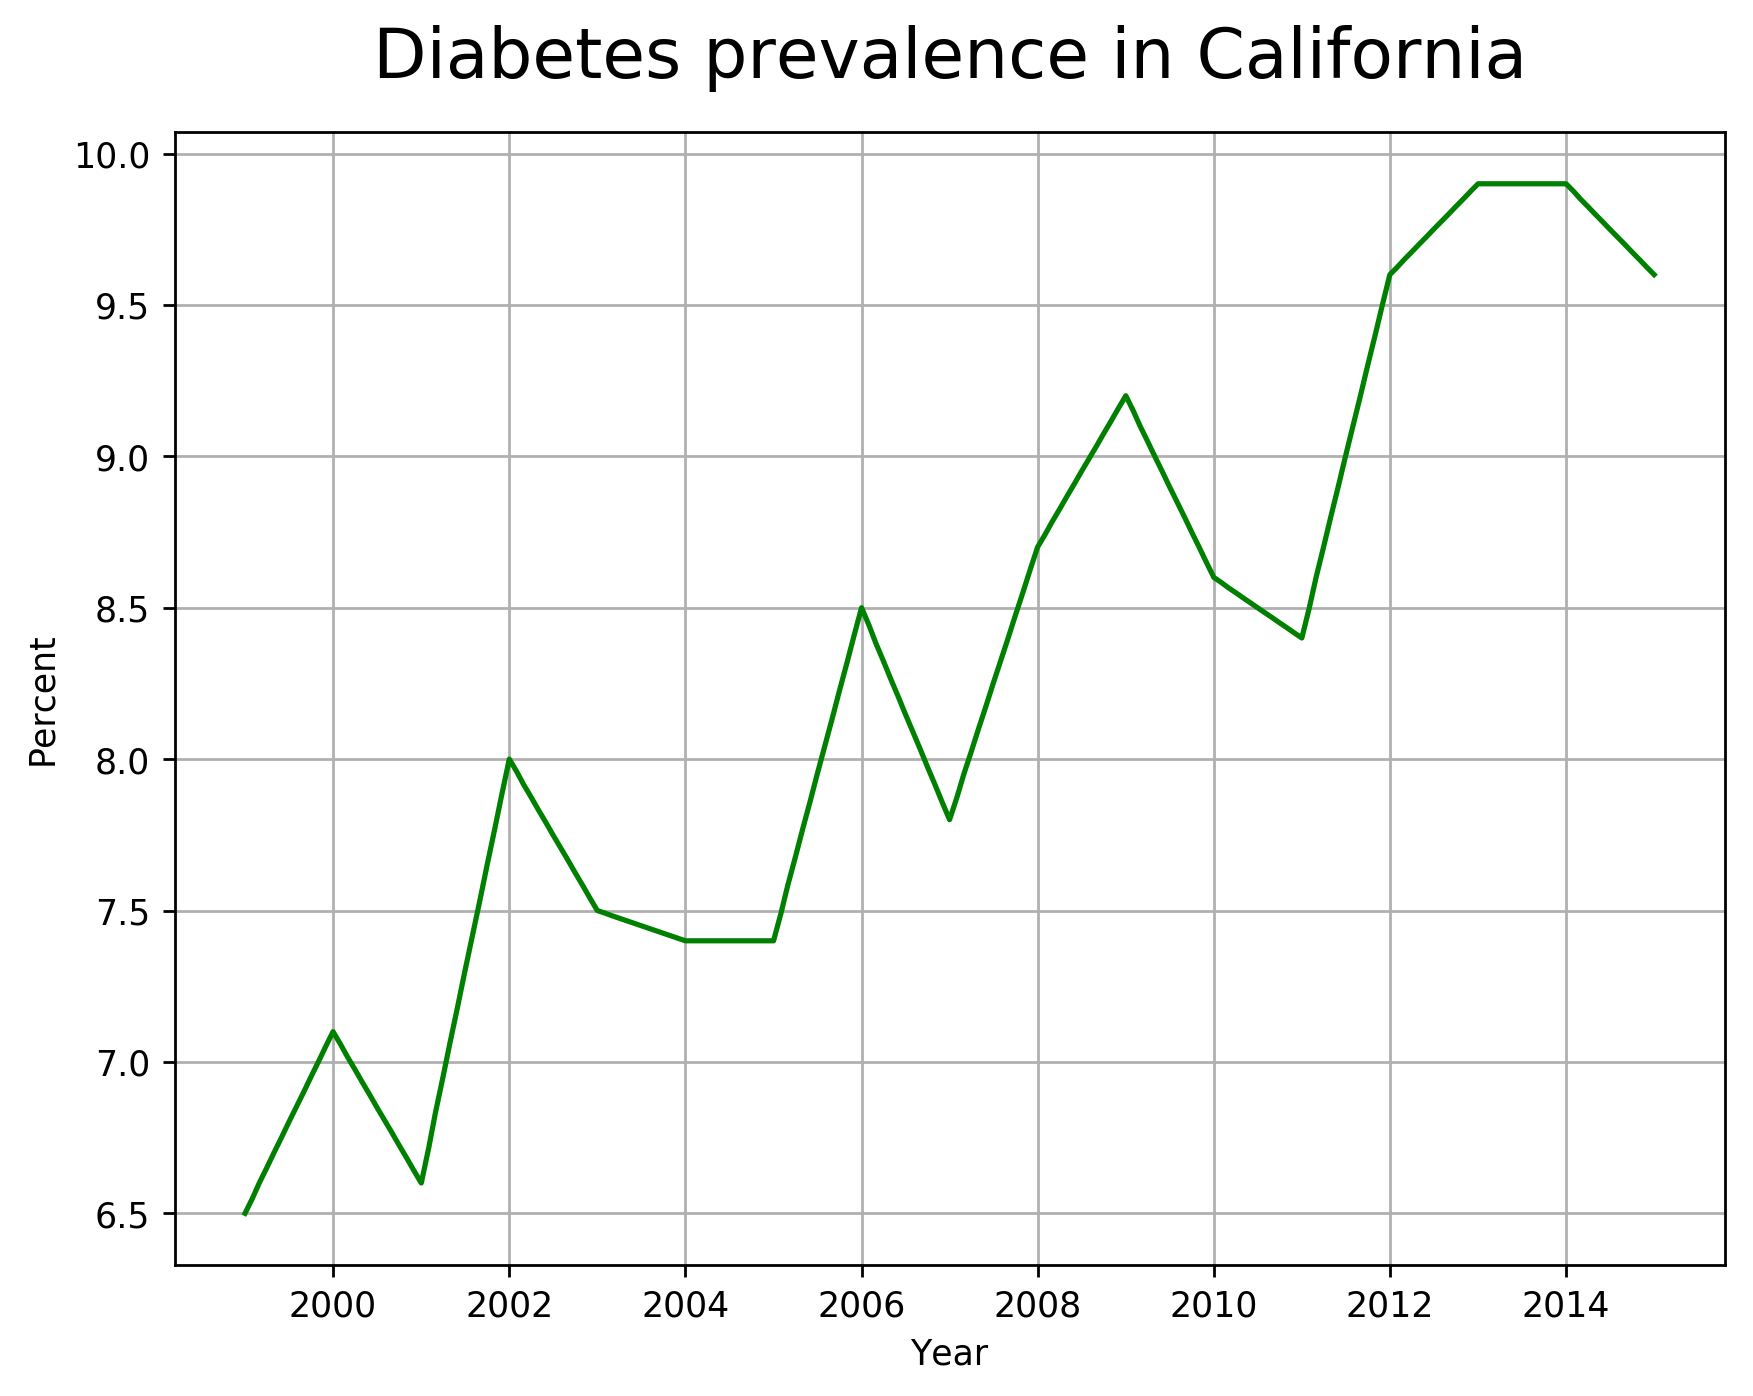

In [13]:
plt.plot(california_df.diabetes_prevalence, 'g', label="diabetes prevalence")
plt.xlabel("Year")
plt.ylabel("Percent")

plt.title("Diabetes prevalence in California", y=1.03)
plt.grid()
plt.savefig("../figures/california_dm_prevalence.png")
plt.show()

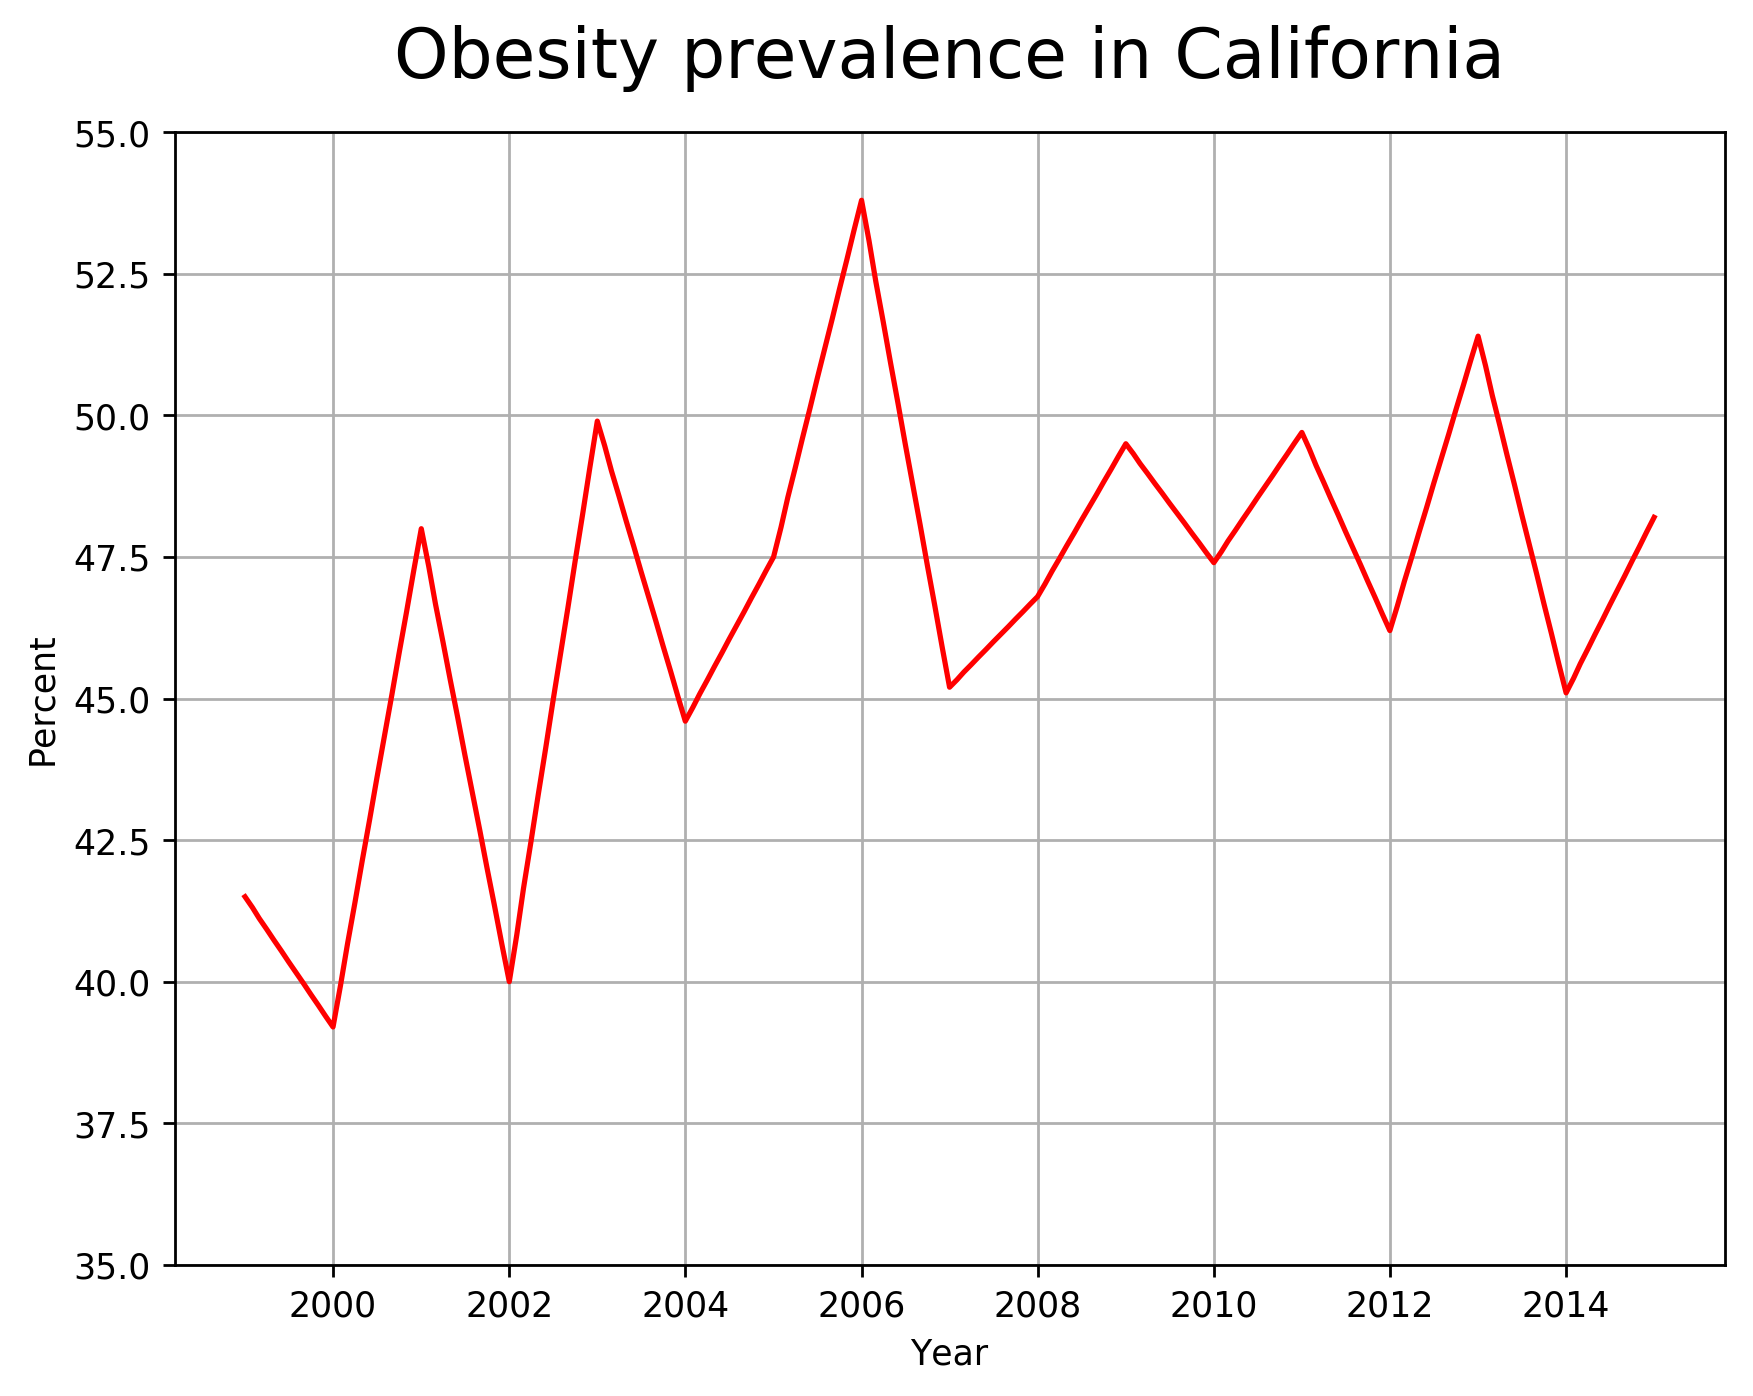

In [14]:
plt.plot(california_df.obesity_prevalence, 'r', label="obesity prevalence")
plt.xlabel("Year")
plt.ylabel("Percent")
axes = plt.gca()
axes.set_ylim([35,55])
plt.title("Obesity prevalence in California", y=1.03)
plt.grid()
plt.savefig("../figures/california_obesity_prevalence.png")
plt.show()

Even just looking at raw data for these two predictors, a model with these covariates fed straight in is going to give some weird results; clearly deaths due to heart attack have been dropping over the past 16 years, but obesity and diabetes prevalence have been going up, which means that any model would conclude that higher rates of obesity and diabetes are associated with decreased deaths from heart attacks. There are a couple potential explanations for this, and probably both are contributory: 1) there's a lag time between when higher rates of obesity and diabetes end up translating into more deaths from heart attacks, and that lag time could potentially be years and we just don't have enough target data to see that increase yet, and 2) that medical care has been getting better to the point that even if there are more people at risk of having heart attacks or having heart attacks, modern medicine is decreasing the total number of people who die from heart attacks anyways.